In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
##
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect ### can you add inspect to line above?

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [9]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Inspect to see station column names and types
columns = inspector.get_columns('station')
print("station table column names and type:")
for column in columns:
    print(column["name"], column["type"])

station table column names and type:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Inspect to see measurement column names and types
columns = inspector.get_columns('measurement')
print("measurement table column names and type:")
for column in columns:
    print(column["name"], column["type"])

measurement table column names and type:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# preview first 5 rows for station
station_df = pd.read_sql_table("station", conn)
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [12]:
# preview first 5 rows for measurements
measurement_df = pd.read_sql_table("measurement", conn)
measurement_df.sort_values(by="date", ascending= False).head()

,id,station,date,prcp,tobs
19549,19550,USC00516128,2017-08-23,0.45,76.0
12186,12187,USC00519523,2017-08-23,0.08,82.0
2723,2724,USC00519397,2017-08-23,0.00,81.0
7634,7635,USC00514830,2017-08-23,0.00,82.0
12185,12186,USC00519523,2017-08-22,0.00,82.0


# Exploratory Precipitation Analysis

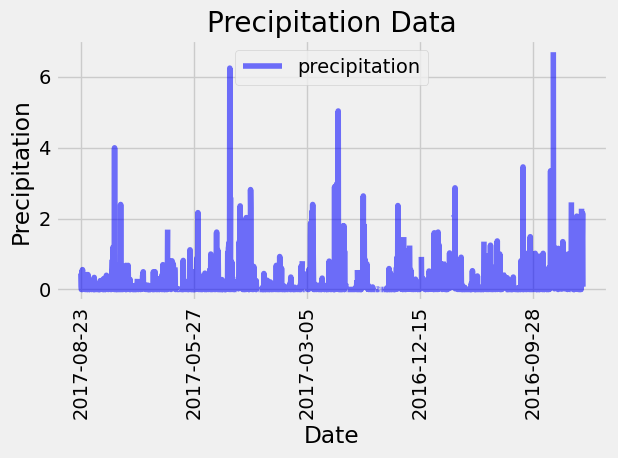

In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# Date is a text not datetime so convert first.
most_recent_date = session.query(measurement.date).\
                    order_by(measurement.date.desc()).first()

prev_year = dt.date(2017,8,23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_query = session.query(measurement.date, measurement.prcp).\
            filter(measurement.date > prev_year).all()
    
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_query).rename(columns={
            'prcp': 'precipitation'
            })

# Sort the dataframe by date
precip_df = precip_df.sort_values(by="date", ascending= False)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x="date",y="precipitation",rot=90, color='blue', alpha=0.55)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation Data")
plt.tight_layout()
plt.show()

In [46]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_stats = round(precip_df.describe(),2)

#print
precip_stats

,precipitation
count,365.00
mean,0.97
std,1.78
min,0.00
25%,0.05
50%,0.40
75%,1.08
max,14.28


# Exploratory Station Analysis

In [48]:
# Design a query to calculate the total number of stations in the dataset
tot_stations = session.query(station.station).distinct().count()
print(tot_stations)

9


In [49]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
## session.query(measurement.station, measurement.station.count()).\
##         sort_by(by = measurement.station.count(), ascending=False)

# Query to count occurrences of each station and sort by this count in descending order
station_counts = session.query(measurement.station, 
    func.count(measurement.station).label('total')).group_by(measurement.station).\
    order_by(func.count(measurement.station).desc())

# Print each station and its count
for station, count in station_counts:
    print(station, count)
    most_active_station = station[0]

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_counts[0][0]

temp_data = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter_by(station = most_active_station)

for x in temp_data:
    print(x)

(54.0, 85.0, 71.66378066378067)


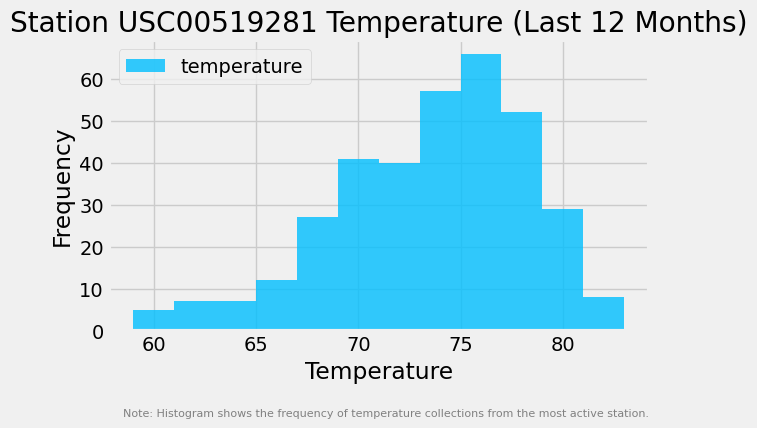

In [51]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the data and precipitation scores
temp_query = session.query(measurement.date, measurement.tobs).\
                filter(measurement.date > last_12_months).\
                filter(measurement.station == most_active_station)
    
# Save the query results as a Pandas DataFrame. Sort the dataframe by date
temp_df = pd.DataFrame(temp_query, columns=['date', 'temperature'])
temp_df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
temp_df.plot(kind='hist', bins=12, color='deepskyblue', alpha=0.80)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"Station {most_active_station} Temperature (Last 12 Months)")

# Adding a note to the figure
plt.text(1, -0.3, 'Note: Histogram shows the frequency of temperature collections from the most active station.',
         verticalalignment='bottom', horizontalalignment='right',
         transform=plt.gca().transAxes, # This ensures the text is placed relative to the axes
         color='grey', fontsize=8)

plt.tight_layout()
plt.show()

# Close Session

In [35]:
# Close Session
session.close()